In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download 11-785-fall-20-homework-2-part-2

100% 1.35G/1.35G [00:44<00:00, 40.3MB/s]
100% 1.35G/1.35G [00:44<00:00, 32.6MB/s]


In [ ]:
! unzip 11-785-fall-20-homework-2-part-2.zip


Streaming output truncated to the last 5000 lines.
  inflating: verification_data/00064099.jpg  
  inflating: verification_data/00064100.jpg  
  inflating: verification_data/00064101.jpg  
  inflating: verification_data/00064102.jpg  
  inflating: verification_data/00064103.jpg  
  inflating: verification_data/00064104.jpg  
  inflating: verification_data/00064105.jpg  
  inflating: verification_data/00064106.jpg  
  inflating: verification_data/00064107.jpg  
  inflating: verification_data/00064108.jpg  
  inflating: verification_data/00064109.jpg  
  inflating: verification_data/00064110.jpg  
  inflating: verification_data/00064111.jpg  
  inflating: verification_data/00064112.jpg  
  inflating: verification_data/00064113.jpg  
  inflating: verification_data/00064114.jpg  
  inflating: verification_data/00064115.jpg  
  inflating: verification_data/00064116.jpg  
  inflating: verification_data/00064117.jpg  
  inflating: verification_data/00064118.jpg  
  inflating: verification_dat

In [ ]:
# Import all the necessary libraries
import PIL
import numpy as np
import torch
import sys
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms
from sklearn.metrics import roc_auc_score, roc_curve, auc
import time


In [ ]:
def getLoaders(trainDS, devDS, testDS, batchS):
    print("*** Create data loader ***")

    # Train
    loader_args = dict(shuffle=True, batch_size=batchS, num_workers=8, pin_memory=True)
    train_loader = DataLoader(trainDS, **loader_args)

    # Dev
    dev_loader = DataLoader(devDS, **loader_args)

    # Test
    test_loader_args = dict(shuffle=False, batch_size=100, num_workers=1, pin_memory=True)
    test_loader = DataLoader(testDS, **test_loader_args)

    return train_loader, dev_loader, test_loader

In [ ]:
dataFolder = "/content/classification_data"

# **Metric Learning**

In [ ]:
cuda = torch.cuda.is_available()
class TripletDataset(Dataset):
  def __init__(self, dataset):
      self.dataset = dataset
      self.labels = np.array([item[1] for item in dataset])  # assuming each item is (image, label)

  def __getitem__(self, index):
      anchor, label = self.dataset[index]
      positive_index = index
      while positive_index == index:  # ensure different image for positive example
          positive_index = np.random.choice(np.where(self.labels == label)[0])
      negative_index = np.random.choice(np.where(self.labels != label)[0])
      positive = self.dataset[positive_index][0]
      negative = self.dataset[negative_index][0]
      return anchor, positive, negative

  def __len__(self):
      return len(self.dataset)
# Load raw data
print("*** Load raw data ***")
train = datasets.ImageFolder(root=dataFolder+"/train_data",
                            transform=transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()]))

dev = datasets.ImageFolder(root=dataFolder+"/val_data",
                           transform=transforms.ToTensor())

test = datasets.ImageFolder(root=dataFolder+"/test_data",
                           transform=transforms.ToTensor())o7kk

# Convert to TripletDataset
train = TripletDataset(train)
dev = TripletDataset(dev)
test = TripletDataset(test)

print("train data stat: {} images \t {} classes".format(len(train), len(train.dataset.classes)))
print("dev data stat: {} images \t {} classes".format(len(dev), len(dev.dataset.classes)))
print("test data stat: {} images \t {} classes".format(len(test), len(test.dataset.classes)))

# Create data loaders
train_loader, dev_loader, test_loader = getLoaders(train, dev, test, 256)


*** Load raw data ***
train data stat: 380638 images 	 4000 classes
dev data stat: 8000 images 	 4000 classes
test data stat: 8000 images 	 4000 classes
*** Create data loader ***


In [ ]:
class MetricLearningNetwork(nn.Module): #Metric Learning
    def __init__(self, feat_dim=1280):
        super(MetricLearningNetwork, self).__init__()

        # Load the pretrained model
        self.net = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)

        # Remove the last layer
        self.net = nn.Sequential(*list(self.net.children())[:-1])

        # Add your custom embedding layer
        self.embedding = nn.Linear(feat_dim, 128)  # output size of 128 for the embedding

    def forward(self, x):
        x = self.net(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)  # flatten
        embedding_out = self.embedding(x)
        return embedding_out

In [ ]:
print("*** Create the model and define  Loss and Optimizer ***")
model = MetricLearningNetwork()
criterion = nn.TripletMarginLoss(margin=1.0, p=2)  # Triplet loss for metric learning
optimizer = torch.optim.Adam(model.parameters(), 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.8, patience=1)
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

*** Create the model and define  Loss and Optimizer ***


Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 93.3MB/s]


Network(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1,

In [ ]:
def train_epoch(model, data_loader, criterion, optimizer, epoch): #task="Metric Learning"
    model.train()
    running_loss = 0.0
    start_time = time.time()
    for batch_idx, (anchor, positive, negative) in enumerate(data_loader):  # data loader should return triplets
        optimizer.zero_grad()
        anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()

        anchor_output = model(anchor)
        positive_output = model(positive)
        negative_output = model(negative)
        loss = criterion(anchor_output, positive_output, negative_output)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        # clear computation cache
        torch.cuda.empty_cache()
        del anchor
        del positive
        del negative
        del loss
    end_time = time.time()
    running_loss = running_loss / len(data_loader)
    return running_loss

In [ ]:
def testEmbeddings(model, test_loader, criterion, epoch):
    with torch.no_grad():
        model.eval()
        embeddings = []  # store embeddings for all test images
        labels = []  # store labels for all test images
        start_time = time.time()
        correct_predictions = 0.0
        total_predictions = 0.0
        running_loss = 0.0
        for batch_idx, (anchor, positive, negative) in enumerate(test_loader):
            anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()

            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)
            embeddings.append(anchor_output.cpu().numpy())
            labels.append(positive.cpu().numpy())  # assuming positive contains the labels

            # calculate loss
            loss = criterion(anchor_output, positive_output, negative_output)
            running_loss += loss.item()

            if batch_idx % 500 == 0:
                print("Epoch: {}\tBatch: {}\tTimestamp: {}".format(epoch, batch_idx, time.time()-start_time))

            # calculate accuracy
            positive_distance = F.pairwise_distance(anchor_output, positive_output)
            negative_distance = F.pairwise_distance(anchor_output, negative_output)
            correct_predictions += (positive_distance < negative_distance).sum().item()
            total_predictions += positive_distance.size(0)

        embeddings = np.concatenate(embeddings)
        labels = np.concatenate(labels)
        acc = (correct_predictions / total_predictions) * 100.0
        running_loss /= len(test_loader)
        return running_loss, acc


In [ ]:
# Train the metric learning model for N epochs
print("*** Train the model for N epochs ***")
Train_loss = []
Train_acc = []
Test_loss = []
Test_acc = []
task = "Classification"
for i in range(10):
    for prarm_group in optimizer.param_groups:
        print("Current lr: \t{}".format(prarm_group["lr"]))
    startTime = time.time()
    train_loss = train_epoch(model, train_loader, criterion, optimizer, i)
    if task == "Classification":
        train_loss, train_acc = testEmbeddings(model, train_loader, criterion, i)
        dev_loss, dev_acc = testEmbeddings(model, dev_loader,criterion, i)
        print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}\tVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.
              format(train_loss, train_acc, dev_loss, dev_acc))
    else:
        print("Verification task")
    scheduler.step(dev_loss)
    Train_loss.append(train_loss)
    Train_acc.append(train_acc)
    Test_loss.append(dev_loss)
    Test_acc.append(dev_acc)
    print("="*20 + " Epoch {} took {}s".format(i, time.time()-startTime) + "="*20)

*** Train the model for N epochs ***
Current lr: 	0.1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0	Batch: 0	Timestamp: 1.339797019958496
Epoch: 0	Batch: 500	Timestamp: 66.659912109375
Epoch: 0	Batch: 1000	Timestamp: 129.50158715248108
Epoch: 0	Batch: 0	Timestamp: 2.2986912727355957
Train Loss: 0.5451	Train Accuracy: 76.2901	Val Loss: 0.5536	Val Accuracy: 76.2000
==================== Epoch 0 took 590.899521112442s====================
Current lr: 	0.1
Epoch: 1	Batch: 0	Timestamp: 2.5345494747161865
Epoch: 1	Batch: 500	Timestamp: 69.17534923553467
Epoch: 1	Batch: 1000	Timestamp: 133.7391951084137
Epoch: 1	Batch: 0	Timestamp: 2.3143036365509033
Train Loss: 0.4674	Train Accuracy: 79.8441	Val Loss: 0.4767	Val Accuracy: 79.4875
==================== Epoch 1 took 601.1010940074921s====================
Current lr: 	0.1
Epoch: 2	Batch: 0	Timestamp: 2.721390724182129
Epoch: 2	Batch: 500	Timestamp: 68.81312012672424
Epoch: 2	Batch: 1000	Timestamp: 133.72789001464844
Epoch: 2	Batch: 0	Timestamp: 2.2194881439208984
Train Loss: 0.4700	Train Accuracy: 79.9164	Val Loss: 0.4525	Val Accuracy: 

# **Classification**

In [ ]:
cuda = torch.cuda.is_available()

print("*** Load raw data ***")
train = datasets.ImageFolder(root=dataFolder+"/train_data",
                            transform=transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()]))

dev = datasets.ImageFolder(root=dataFolder+"/val_data",
                           transform=transforms.ToTensor())

test = datasets.ImageFolder(root=dataFolder+"/test_data",
                           transform=transforms.ToTensor())

print("train data stat: {} images \t {} classes".format(train.__len__(), len(train.classes)))
print("dev data stat: {} images \t {} classes".format(dev.__len__(), len(dev.classes)))
print("test data stat: {} images \t {} classes".format(dev.__len__(), len(test.classes)))

train_loader, dev_loader, test_loader = getLoaders(train, dev, test, 64)

*** Load raw data ***
train data stat: 380638 images 	 4000 classes
dev data stat: 8000 images 	 4000 classes
test data stat: 8000 images 	 4000 classes
*** Create data loader ***


In [ ]:
train.__getitem__(1)[0].shape

torch.Size([3, 64, 64])

In [ ]:
class ClassificationNetwork(nn.Module): #Classification
    def __init__(self, numClasses, feat_dim=1280):
        super(ClassificationNetwork, self).__init__()

        # Load the pretrained model
        self.net = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)

        # Remove the last layer
        self.net = nn.Sequential(*list(self.net.children())[:-1])

        # Add your custom classifier
        self.classifier = nn.Linear(feat_dim, numClasses)

    def forward(self, x):
        x = self.net(x)
        output = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1) # flatten
        classification_out = self.classifier(output)
        embedding_out = output
        return embedding_out, classification_out


In [ ]:
# Create the model and define the Loss and Optimizer
print("*** Create the model and define  Loss and Optimizer ***")
outputSize = len(train.classes)     # number of unique face classes
model = ClassificationNetwork(outputSize)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9,\
                      #nesterov=True, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.8, patience=1)
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)


*** Create the model and define  Loss and Optimizer ***


Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 88.5MB/s]


ClassificationNetwork(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 

In [ ]:
def train_epoch(model, data_loader, criterion, optimizer, epoch): #task="Classification")
    model.train()
    running_loss = 0.0
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        data, target = data.cuda(), target.cuda()

        outputs = model(data)[1]
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        # clear computation cache
        torch.cuda.empty_cache()
        del data
        del target
        del loss
    end_time = time.time()
    running_loss = running_loss / len(data_loader)
    return running_loss

In [ ]:
def testClassify(model, test_loader, epoch):
    with torch.no_grad():
        model.eval()
        start_time = time.time()
        running_loss = 0.0
        correct_predictions = 0.0
        total_predictions = 0.0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.cuda(), target.cuda()

            outputs = model(data.float())[1]
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, target.long()).detach()
            total_predictions += target.size(0)
            correct_predictions += (predicted==target).sum().item()
            running_loss += loss.item()
            if batch_idx % 500 == 0:
                print("Epoch: {}\tBatch: {}\tTimestamp: {}".format(epoch, batch_idx, time.time()-start_time))
            del data
            del target
        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        return running_loss, acc

In [ ]:
# Train the Classification model for N epochs
print("*** Train the model for N epochs ***")
Train_loss = []
Train_acc = []
Test_loss = []
Test_acc = []
task = "Classification"
for i in range(50):
    for prarm_group in optimizer.param_groups:
        print("Current lr: \t{}".format(prarm_group["lr"]))
    startTime = time.time()
    train_loss = train_epoch(model, train_loader,criterion, optimizer, i)
    if task == "Classification":
        train_loss, train_acc = testClassify(model, train_loader, i)
        dev_loss, dev_acc = testClassify(model, dev_loader, i)
        print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}\tVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.
              format(train_loss, train_acc, dev_loss, dev_acc))
    else:
        print("Verification task")
    scheduler.step(dev_loss)
    Train_loss.append(train_loss)
    Train_acc.append(train_acc)
    Test_loss.append(dev_loss)
    Test_acc.append(dev_acc)
    print("="*20 + " Epoch {} took {}s".format(i, time.time()-startTime) + "="*20)

*** Train the model for N epochs ***
Current lr: 	0.001


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0	Batch: 0	Timestamp: 0.3970649242401123
Epoch: 0	Batch: 500	Timestamp: 5.7166526317596436
Epoch: 0	Batch: 1000	Timestamp: 11.205374240875244
Epoch: 0	Batch: 1500	Timestamp: 17.158363342285156
Epoch: 0	Batch: 2000	Timestamp: 22.588564157485962
Epoch: 0	Batch: 2500	Timestamp: 27.937591552734375
Epoch: 0	Batch: 3000	Timestamp: 33.755706787109375
Epoch: 0	Batch: 3500	Timestamp: 39.2098388671875
Epoch: 0	Batch: 4000	Timestamp: 44.773460388183594
Epoch: 0	Batch: 4500	Timestamp: 50.54607605934143
Epoch: 0	Batch: 5000	Timestamp: 56.09405040740967
Epoch: 0	Batch: 5500	Timestamp: 61.454325437545776
Epoch: 0	Batch: 0	Timestamp: 0.30885744094848633
Train Loss: 6.3480	Train Accuracy: 1.8214	Val Loss: 6.5637	Val Accuracy: 1.2625
==================== Epoch 0 took 328.07333970069885s====================
Current lr: 	0.001
Epoch: 1	Batch: 0	Timestamp: 0.30469369888305664
Epoch: 1	Batch: 500	Timestamp: 5.739158391952515
Epoch: 1	Batch: 1000	Timestamp: 11.25112533569336
Epoch: 1	Batch: 1500	Times

# **Verification**

**VERIFICATION USING SELF-SUPERVISED LEARNING**

In [ ]:
class MyDatasetVerify(Dataset):
    # Create dataset for validation of verification tast
    def __init__(self, pairFN, imgFolderPath):
        self.imgFolderPath = imgFolderPath
        with open(pairFN) as f:
          self.pairList = [line.rstrip().replace('verification_data/', '') for line in f]

    def __len__(self):
        return len(self.pairList)
    def __getitem__(self, idx):
        items = self.pairList[idx].split()
        fn1, fn2 = items[0], items[1]
        img1 = PIL.Image.open(self.imgFolderPath + fn1)
        img2 = PIL.Image.open(self.imgFolderPath + fn2)
        img1 = transforms.ToTensor()(img1)
        img2 = transforms.ToTensor()(img2)
        if len(items) == 3: # validation
            return img1, img2, int(items[2])
        else: # test
            return img1, img2, -1
    def getPairList(self):
        return self.pairList

In [ ]:
def testVerify(model, vLoader):
    similarity = np.array([])
    true = np.array([])
    start_time = time.time()
    with torch.no_grad():
        start_time = time.time()
        for batch_idx, (imgs1, imgs2, targets) in enumerate(vLoader):
            imgs1, imgs2, targets = imgs1.cuda(), imgs2.cuda(), targets.cuda()
            # find cos similarity between embeddings
            imgs1Embed = model(imgs1.float())
            imgs2Embed = model(imgs2.float())
            sim = F.cosine_similarity(imgs1Embed, imgs2Embed) # Cosine
            #sim = F.pairwise_distance(imgs1Embed, imgs2Embed) # Euclidean
            similarity = np.concatenate((similarity, sim.cpu().numpy().reshape(-1)))
            true = np.concatenate((true, targets.cpu().numpy().reshape(-1)))
            if batch_idx % 100 == 0:
                print("Batch: {}\t Timestamp:{}".format(batch_idx, time.time()-start_time))
            del imgs1
            del imgs2
            del targets
    return similarity, true

In [ ]:
# Read in verification pairs for validation
verifyData_valid = MyDatasetVerify("/content/verification_pairs_val.txt", "/content/verification_data/")
verify_loader_args_valid = dict(shuffle=False, batch_size=200, num_workers=8, pin_memory=True)
verify_loader_valid = DataLoader(verifyData_valid, **verify_loader_args_valid)

In [ ]:
print("Verification validation data stat: {} pairs \t".format(verifyData_valid.__len__()))


Verification validation data stat: 8805 pairs 	


In [ ]:
# Plot the ROC curve and calculate AUC
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch: 0	 Timestamp:0.4951822757720947


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


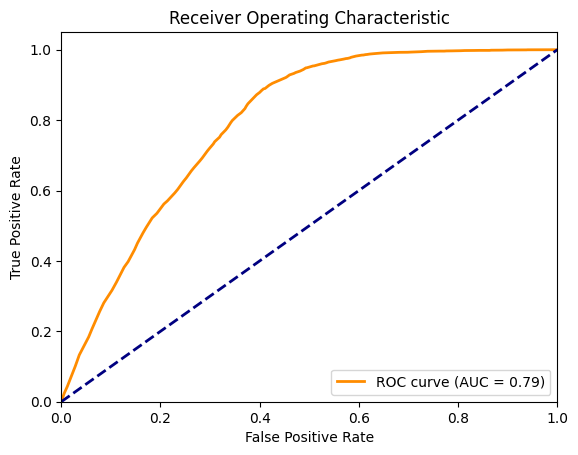

*** AUC: 0.7910990562264024 ***


In [ ]:
# Calculate simliarity score
cosScore_valid, trueScore_valid = testVerify(metricmodel, verify_loader_valid)

# Report AUC
fpr, tpr, thresholds = roc_curve(trueScore_valid, cosScore_valid)
auc = roc_auc_score(trueScore_valid, cosScore_valid)
plot = plot_roc_curve(trueScore_valid, cosScore_valid)
print("*** AUC: {} ***".format(auc))

**VERIFICATION USING SUPERVISED LEARNING**

In [ ]:
class MyDatasetVerify(Dataset):
    # Create dataset for validation of verification tast
    def __init__(self, pairFN, imgFolderPath):
        self.imgFolderPath = imgFolderPath
        with open(pairFN) as f:
          self.pairList = [line.rstrip().replace('verification_data/', '') for line in f]

    def __len__(self):
        return len(self.pairList)
    def __getitem__(self, idx):
        items = self.pairList[idx].split()
        fn1, fn2 = items[0], items[1]
        img1 = PIL.Image.open(self.imgFolderPath + fn1)
        img2 = PIL.Image.open(self.imgFolderPath + fn2)
        img1 = transforms.ToTensor()(img1)
        img2 = transforms.ToTensor()(img2)
        if len(items) == 3: # validation
            return img1, img2, int(items[2])
        else: # test
            return img1, img2, -1
    def getPairList(self):
        return self.pairList

In [ ]:
def testVerify(model, vLoader):
    similarity = np.array([])
    true = np.array([])
    start_time = time.time()
    with torch.no_grad():
        start_time = time.time()
        for batch_idx, (imgs1, imgs2, targets) in enumerate(vLoader):
            imgs1, imgs2, targets = imgs1.cuda(), imgs2.cuda(), targets.cuda()
            # find cos similarity between embeddings
            imgs1Embed = model(imgs1.float())[0]
            imgs2Embed = model(imgs2.float())[0]
            sim = F.cosine_similarity(imgs1Embed, imgs2Embed)
            similarity = np.concatenate((similarity, sim.cpu().numpy().reshape(-1)))
            true = np.concatenate((true, targets.cpu().numpy().reshape(-1)))
            if batch_idx % 100 == 0:
                print("Batch: {}\t Timestamp:{}".format(batch_idx, time.time()-start_time))
            del imgs1
            del imgs2
            del targets
    return similarity, true

In [ ]:
# Read in verification pairs for validation
verifyData_valid = MyDatasetVerify("/content/verification_pairs_val.txt", "/content/verification_data/")
verify_loader_args_valid = dict(shuffle=False, batch_size=200, num_workers=8, pin_memory=True)
verify_loader_valid = DataLoader(verifyData_valid, **verify_loader_args_valid)

In [ ]:
print("Verification validation data stat: {} pairs \t".format(verifyData_valid.__len__()))


Verification validation data stat: 8805 pairs 	


In [ ]:
# Plot the ROC curve and calculate AUC
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch: 0	 Timestamp:1.9943218231201172


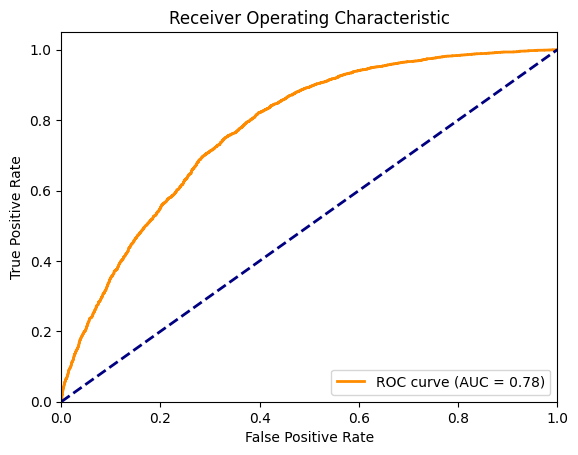

*** AUC: 0.7751581085300926 ***


In [ ]:
# Calculate simliarity score
cosScore_valid, trueScore_valid = testVerify(clasificationmodel, verify_loader_valid)

# Report AUC
fpr, tpr, thresholds = roc_curve(trueScore_valid, cosScore_valid)
auc = roc_auc_score(trueScore_valid, cosScore_valid)
plot = plot_roc_curve(trueScore_valid, cosScore_valid)
print("*** AUC: {} ***".format(auc))

# **Save and Load Model**

**SAVE MODEL**

In [ ]:
torch.save(model.state_dict(), 'model.pth')


**LOAD METRIC LEARING MODEL**

In [ ]:
import torch
import torch.nn as nn
class MetricLearningNetwork(nn.Module): #Metric Learning
    def __init__(self, feat_dim=1280):
        super(MetricLearningNetwork, self).__init__()

        # Load the pretrained model
        self.net = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)

        # Remove the last layer
        self.net = nn.Sequential(*list(self.net.children())[:-1])

        # Add your custom embedding layer
        self.embedding = nn.Linear(feat_dim, 128)  # output size of 128 for the embedding

    def forward(self, x):
        x = self.net(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)  # flatten
        embedding_out = self.embedding(x)
        return embedding_out

# Initialize the model
metricmodel = MetricLearningNetwork()

# Load the state dict previously saved
state_dict = torch.load('/content/model-metric-learning.pth')
metricmodel.load_state_dict(state_dict)
metricmodel.to(torch.device('cuda'))


Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 103MB/s] 


MetricLearningNetwork(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 

In [ ]:
import torch
import torch.nn as nn

class ClassificationNetwork(nn.Module): #Classification
    def __init__(self, numClasses, feat_dim=1280):
        super(ClassificationNetwork, self).__init__()

        # Load the pretrained model
        self.net = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)

        # Remove the last layer
        self.net = nn.Sequential(*list(self.net.children())[:-1])

        # Add your custom classifier
        self.classifier = nn.Linear(feat_dim, numClasses)

    def forward(self, x):
        x = self.net(x)
        output = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1) # flatten
        classification_out = self.classifier(output)
        embedding_out = output
        return embedding_out, classification_out


# Initialize the model
clasificationmodel = ClassificationNetwork(4000)

# Load the state dict previously saved
state_dict = torch.load('/content/model-classification.pth')
clasificationmodel.load_state_dict(state_dict)
clasificationmodel.to(torch.device('cuda'))


Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 97.9MB/s]


ClassificationNetwork(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 